# Gesture Recognition
### By: Tomomi Bahun & Joshua Turner

The authors of this project set out with the intended goal of finding a deep learning approach to solve the problems of both the detection and classification of a predefined set of hand gestures. The hand gestures chosen for this project consisted of four individuals hand signals: like (thumbs up), dislike (thumbs down), ok (ok hand sign), and stop (open hand). This topic was chosen because it allowed the authors the opportunity to explore deep learning solutions, as well as practice the proper techniques in data collection and annotation. The authors were also interested in this topic because with an adequate solution to the stated problem, the approach could be extended into real world applications such as American Sign Language (ASL) translation or cyclist signalling detection in autonomous vehicles.

This notebook will be documented with a general walkthrough of the current solution, with points of discussion and suggestions on future improvement for the authors.

This notebook expects a certain file/folder structure, and as such it's easier to run when hooked to a personal drive with the necessary components if running in a Colab environment. The necessary components will include:
*   A 'data' directory in the same directory as the notebook
  *   A \<dataset\> directory of arbitary name within the data directory
      *   An 'images' folder, containing all images for the dataset
      *   A 'labels' folder, containing yolo format annotation text files of the same names as the corresponding images in the 'images' folder
      *   A 'train.txt' file containing a list of all images in the training set, separate by newlines
      *   A 'valid.txt' file containing a list of all images in the validation set, separated by newlines
      *   A 'test.txt' file containing a list of all images in the test set, separated by newlines

A notebook was written to automatically split the full dataset found in the 'images' folder and write those lists to the corresponding text files as mentioned above. This notebook will be posted in the same repo as this notebook. 



In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Both PIL and Albumentation packages caused issues due to Colabs default versioning. They both need to be upgraded if running in a Colab environment.

In [2]:
! pip install --upgrade albumentations
! pip install --upgrade Pillow

You should consider upgrading via the '/opt/anaconda3/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/anaconda3/bin/python3.6 -m pip install --upgrade pip' command.


In [3]:
import os
import numpy as np
import torch
import torchvision
import torchvision.utils as utils
import matplotlib.pyplot as plt
import albumentations as A
import cv2

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torchvision.ops import *
from typing import Optional, List, Union, Tuple
from PIL import Image, ImageDraw, ImageFont, ImageColor, ImageOps
from sklearn.metrics import confusion_matrix, accuracy_score

Helper function to draw bounding boxes on a given image, pulled directly from the [torchvision source code](https://github.com/pytorch/vision/blob/master/torchvision/utils.py) to circumvent the need to install the entire module directly from source.

In [4]:
def draw_bounding_boxes(
    image: torch.Tensor,
    boxes: torch.Tensor,
    labels: Optional[List[str]] = None,
    colors: Optional[List[Union[str, Tuple[int, int, int]]]] = None,
    fill: Optional[bool] = False,
    width: int = 1,
    font: Optional[str] = None,
    font_size: int = 10
) -> torch.Tensor:

    """
    Draws bounding boxes on given image.
    The values of the input image should be uint8 between 0 and 255.
    If fill is True, Resulting Tensor should be saved as PNG image.
    Args:
        image (Tensor): Tensor of shape (C x H x W) and dtype uint8.
        boxes (Tensor): Tensor of size (N, 4) containing bounding boxes in (xmin, ymin, xmax, ymax) format. Note that
            the boxes are absolute coordinates with respect to the image. In other words: `0 <= xmin < xmax < W` and
            `0 <= ymin < ymax < H`.
        labels (List[str]): List containing the labels of bounding boxes.
        colors (List[Union[str, Tuple[int, int, int]]]): List containing the colors of bounding boxes. The colors can
            be represented as `str` or `Tuple[int, int, int]`.
        fill (bool): If `True` fills the bounding box with specified color.
        width (int): Width of bounding box.
        font (str): A filename containing a TrueType font. If the file is not found in this filename, the loader may
            also search in other directories, such as the `fonts/` directory on Windows or `/Library/Fonts/`,
            `/System/Library/Fonts/` and `~/Library/Fonts/` on macOS.
        font_size (int): The requested font size in points.
    Returns:
        img (Tensor[C, H, W]): Image Tensor of dtype uint8 with bounding boxes plotted.
    Example:
        See this notebook
        `linked <https://github.com/pytorch/vision/blob/master/examples/python/visualization_utils.ipynb>`_
    """

    if not isinstance(image, torch.Tensor):
        raise TypeError(f"Tensor expected, got {type(image)}")
    elif image.dtype != torch.uint8:
        raise ValueError(f"Tensor uint8 expected, got {image.dtype}")
    elif image.dim() != 3:
        raise ValueError("Pass individual images, not batches")

    ndarr = image.permute(1, 2, 0).numpy()
    img_to_draw = Image.fromarray(ndarr)

    img_boxes = boxes.to(torch.int64).tolist()

    if fill:
        draw = ImageDraw.Draw(img_to_draw, "RGBA")

    else:
        draw = ImageDraw.Draw(img_to_draw)

    txt_font = ImageFont.load_default() if font is None else ImageFont.truetype(font=font, size=font_size)

    for i, bbox in enumerate(img_boxes):
        if colors is None:
            color = None
        else:
            color = colors[i]

        if fill:
            if color is None:
                fill_color = (255, 255, 255, 100)
            elif isinstance(color, str):
                # This will automatically raise Error if rgb cannot be parsed.
                fill_color = ImageColor.getrgb(color) + (100,)
            elif isinstance(color, tuple):
                fill_color = color + (100,)
            draw.rectangle(bbox, width=width, outline=color, fill=fill_color)
        else:
            draw.rectangle(bbox, width=width, outline=color)

        if labels is not None:
            draw.text((bbox[0], bbox[1]), labels[i], fill=color, font=txt_font)

    return torch.from_numpy(np.array(img_to_draw)).permute(2, 0, 1).to(dtype=torch.uint8)

Helper function to convert yolo annotation format (xywh) to pascal_voc annotation format, pulled from open source [PyTorch YOLOv3 implementation](https://github.com/eriklindernoren/PyTorch-YOLOv3/blob/1675d1898c2ec6e0bca6057b482667a2d884ceb8/pytorchyolo/utils/utils.py#L84) after transitioning from YOLOv3 to Faster-RCNN solution.

In [5]:
def xywh2xyxy(x, w, h):
        y = np.zeros_like(x)
        y[..., 0] = (x[..., 0] - x[..., 2] / 2)*w
        y[..., 1] = (x[..., 1] - x[..., 3] / 2)*h
        y[..., 2] = (x[..., 0] + x[..., 2] / 2)*w
        y[..., 3] = (x[..., 1] + x[..., 3] / 2)*h
        return y

Custom Dataset class to aid in integrating Faster-RCNN solution with original YOLOv3 implementation file/folder structure. Operates on datasets defined by \<set\>.txt files. Also integrates Albumentations transforms if specified.

Transform section will eventually need to be rewritten as Albumentation integration needs to be specified while in use due to conflicts with transform differences between datasets.

In [6]:
class GesturesDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms, names='train.txt'):
        self.root = root
        self.names = names
        self.transforms = transforms
        # Load all images and sort them to ensure they're aligned
        with open(os.path.join(root, names), 'r') as file: 
            self.imgs = list(sorted([f.rstrip().split('/')[-1] for f in file.readlines()]))
            self.labels = list(sorted([f"{f.split('.')[0]}.txt" for f in self.imgs]))
        
    def __getitem__(self, idx):
        # Load images
        img_path = os.path.join(self.root, 'images', self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        img = ImageOps.exif_transpose(img) # Some images have rotation meta tag
        # Load labels
        label_path = os.path.join(self.root, 'labels', self.labels[idx])
        label = np.loadtxt(label_path)
        # Get our bounding box
        box = xywh2xyxy(label[1:], *img.size)
        # Convert everything into tensors
        boxes = torch.tensor([box], dtype=torch.float32)
        labels = torch.tensor((label[0]+1,), dtype=torch.int64) # Account for background class
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        
        # dict for target
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        # This section is needed if using transforms in the training set due to way
        # ToTensor() has been implemented. If you wish to use transforms, uncomment this
        # section and comment the follow section. ONLY USE TRANFORMS ON THE TRAINING SET!
        # if self.names == 'train.txt' and self.transforms is not None:
        #     transformed = self.transforms(image=np.array(img), bboxes=boxes, labels=labels)
        #     img = F.to_tensor(transformed['image'])
        #     target['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
        #     target['labels'] = torch.tensor(transformed['labels'], dtype=torch.int64)
        # elif self.transforms is not None:
        #   img, target = self.transforms(img, target)
        
        # This section can be used if no transforms are being used in the training set.
        # Comment out if using transforms and the above logic.
        if self.transforms is not None:
         img, target = self.transforms(img, target)
        
        return img, target
    
    def __len__(self):
        return len(self.imgs)

Helper function to aid in collating batch data. Pulled directly from [torchvision source code](https://github.com/pytorch/vision/blob/19ad0bbc5e26504a501b9be3f0345381d6ba1efc/references/detection/utils.py#L235).

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

Transform helper class to turn PIL image to torch tensor, pulled directly from [torchvision source code](https://github.com/pytorch/vision/blob/19ad0bbc5e26504a501b9be3f0345381d6ba1efc/references/detection/transforms.py#L46).

In [8]:
class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

Selected transforms that work with bounding boxes. NOTE: HorizontalFlip and Rotate have issues with some of the data in the second dataset (gestures_dataset) due to the bounding boxes. The issue could not be resolved. If you wish you to use transforms on that dataset, you'll need to comment out the top two and it should work.

In [9]:
transforms = A.Compose([A.HorizontalFlip(p=0.5),
                       A.Rotate(limit=[-20,20], p=0.5),
                       A.RGBShift(p=0.5),
                       A.GaussNoise(var_limit=[10.0, 200.0], p=0.5),
                       A.ToGray(p=0.25),
                       A.MotionBlur(blur_limit=[3,50], p=0.5),
                      ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

Creating our datasets. NOTE: If you wish to use transforms, you must specify the above in the train_dataset constructor. If you don't wish to use transforms, simply use 'ToTensor()'. ONLY USE TRANFORMS IN THE TRAINING SET! The current logic will fail otherwise.

In [10]:
# Create our dataset
cwd = os.getcwd()
dataset_path = os.path.join(cwd, './data/tomomiV2_dataset')

classes = ['background', 'like', 'dislike', 'ok', 'stop']
num_classes = len(classes)

# Use 'ToTensor()' for no augmentations, or 'transforms' to include augmentations
train_dataset = GesturesDataset(dataset_path, ToTensor(), 'train.txt')
#train_dataset = GesturesDataset(dataset_path, transforms, 'train.txt')
valid_dataset = GesturesDataset(dataset_path, ToTensor(), 'val.txt')
test_dataset = GesturesDataset(dataset_path, ToTensor(), 'test.txt')

Load our model with pretrained backbone weights.

In [11]:
# Create model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes,
                                                             progress=False, pretrained_backbone=True,
                                                             trainable_backbone_layers=0)

Create our dataloaders. Batchsize of 4 is the highest Colab seems to be able to handle.

In [12]:
batch_size = 4
# IoU Threshold for evaluation
iou_thresh = 0.05

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4,
                                              collate_fn=collate_fn)

valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4,
                                              collate_fn=collate_fn)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4,
                                              collate_fn=collate_fn)

Display an image from the training set. This cell is beneficial if you wish to see the effects of the transforms on the data.

torch.Size([3, 720, 1280])
like


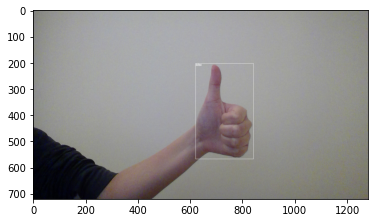

In [13]:
# pick one image from the train set
img, targets = train_dataset[2]
print(img.shape)

boxes = targets['boxes']
labels = targets['labels']
labels = [classes[i] for i in labels]

# Print the image
print(labels[0])
img = draw_bounding_boxes((img * 255).to(torch.uint8), boxes, labels)
plt.imshow(img.permute(1,2,0))

Validation helper function to calcuate the average classification loss over the entire validation set. This can and should be rewritten to be more efficient. Suggestions:
  * Rewrite to utilize the dataloader instead of the dataset. This will allow for validation over a batch, as opposed to the whole set.
  * Include more losses, such as objectness and bounding box regression. The current loss doesn't match the one output by the model during training, and as such, doesn't draw a comparable curve. Reference the source code of the PyTorch implementation to make it more comparable.

In [14]:
def validate(model, valid_losses):
    # Validation
    model.eval()
    with torch.no_grad():
        valid_losses_temp = []
        for i in range(len(valid_dataset)):
            img, target = valid_dataset[i]
            prediction = model([img.to(device)])
            # BBox IoU
            ious = torchvision.ops.box_iou(prediction[0]['boxes'], target['boxes'].to(device)).squeeze(axis=1)
            boxes = prediction[0]['boxes']
            bbox_indices = torchvision.ops.nms(boxes, ious, iou_thresh)
            boxes = boxes[bbox_indices]
            labels = prediction[0]['labels'][bbox_indices]
            if (len(boxes) > 0):
                # Calculate classification loss
                pred_cls = torch.nn.functional.one_hot(labels, 5).float()
                target_cls = torch.tensor([target['labels'].item() for i in pred_cls])
                cls_loss = ce_loss(pred_cls, target_cls.to(device))
                valid_losses_temp.append(cls_loss.item())
        # Average results
        if (len(valid_losses_temp)):
            valid_losses.append(sum(valid_losses_temp)/len(valid_losses_temp))
        else:
            valid_losses.append(None)
    # Put model back in training mode
    model.train()

Main training and validation loop. Epochs can be adjusted here, but the training curve demonstrates little improvement past a couple epochs. Validation will need to be adjusted to see a better representation of training progress.

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

# Construct optimizer
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0005)

# Loss functions
ce_loss = torch.nn.CrossEntropyLoss()

# Learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Lists used to collect losses for plotting
train_losses = []
valid_losses = []
epochs = 10
# For each epoch
for epoch in range(epochs):
    model.train()
    # For each batch
    for i, data in enumerate(train_dataloader, 0):
        imgs, targets = data
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Get our losses
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        #print(f"Total loss: {losses}")
        train_losses.append(losses)
        
        # Validation
        validate(model, valid_losses)
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
#         if lr_scheduler is not None:
#             lr_scheduler.step()

Plot our loss curves for comparision. Again, the current validation curve isn't very accurate as it's missing several key losses the model accounts for. As a result, the gap between the two can't be properly evaluated.

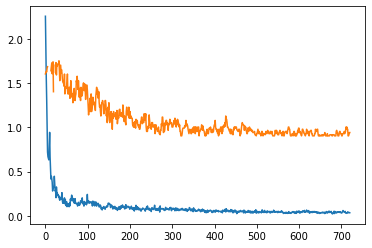

In [16]:
duration = epochs * len(train_dataloader)
x = np.linspace(0, duration, duration)
plt.plot(x, train_losses, x, valid_losses)

Main testing loop. IoU threshold can be defined here. Mainly only accounting for IoU and classification accuracy after NMS filtering. As such, the results are skewed. This testing process will need to include more metrics to better capture the models ability to detect and bound objects, not just to classify them.

In [17]:
# IoU Threshold for evaluation
iou_thresh = 0.05
all_ious = []

# Define our losses
cls_losses = []

# Aggregate results for confusion matrix
y_pred = []
y_true = []

# Count of images with no detections
no_pred = 0

# put the model in evaluation mode
model.eval()
# No gradients
with torch.no_grad():
    # For each image
    for i in range(len(test_dataset)):
        img, target = test_dataset[i]
        # Get predictions
        prediction = model([img.to(device)])
        # BBox IoU
        ious = torchvision.ops.box_iou(prediction[0]['boxes'], target['boxes'].to(device)).squeeze(axis=1)
        all_ious.extend(ious.tolist())
        boxes = prediction[0]['boxes']
        # Filter our results by NMS
        bbox_indices = torchvision.ops.nms(boxes, ious, iou_thresh)
        boxes = boxes[bbox_indices]
        labels = prediction[0]['labels'][bbox_indices]
        # Only calcuate metrics if we have remaining bounding boxes
        if (len(boxes) > 0):
            # Calculate classification loss
            pred_cls = torch.nn.functional.one_hot(labels, 5).float()
            target_cls = torch.tensor([target['labels'].item() for i in pred_cls])
            cls_loss = ce_loss(pred_cls, target_cls.to(device))
            cls_losses.append(cls_loss.item())
            # Append preds and true labels for confusion matrix
            y_pred.extend([l.item() for l in labels])
            y_true.extend([target['labels'].item() for i in pred_cls])
            # Calculate box regression loss
        else:
            no_pred += 1
        

# Print our results
print(f"Average IoU: {round(np.average(all_ious), 4)}")
print(f"Images with no predictions after NMS: {no_pred}")
print(f"Average classification loss: {round(np.average(cls_losses), 4)}")

Average IoU: 0.6612
Images with no predictions after NMS: 0
Average classification loss: 0.9326


Calculate our total accuracy over all classes and display the confusion matrix. Only normalizing over the real label to better visualize the accuracy over correct predictions.

Accuracy across all classes: 0.9726027397260274


/home/joshuaturner/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/home/joshuaturner/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


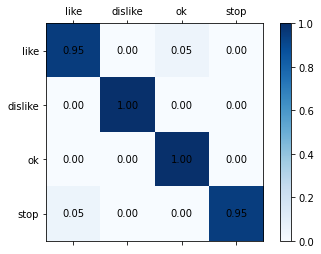

In [18]:
# Accuracy score
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy across all classes: {acc}")

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

fig = plt.figure()
axes = fig.add_subplot(111)
caxes = axes.matshow(conf_matrix, interpolation ='nearest', cmap='Blues')

for (i, j), z in np.ndenumerate(conf_matrix):
    axes.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

fig.colorbar(caxes)
axes.set_xticklabels(['']+classes[1:])
axes.set_yticklabels(['']+classes[1:])
  
plt.show()

Generate and plot predictions on a selected image. This is a good cell to visualize how the model is performing, especially on images outside of any available datasets. Includes NMS to see how it effects the results.

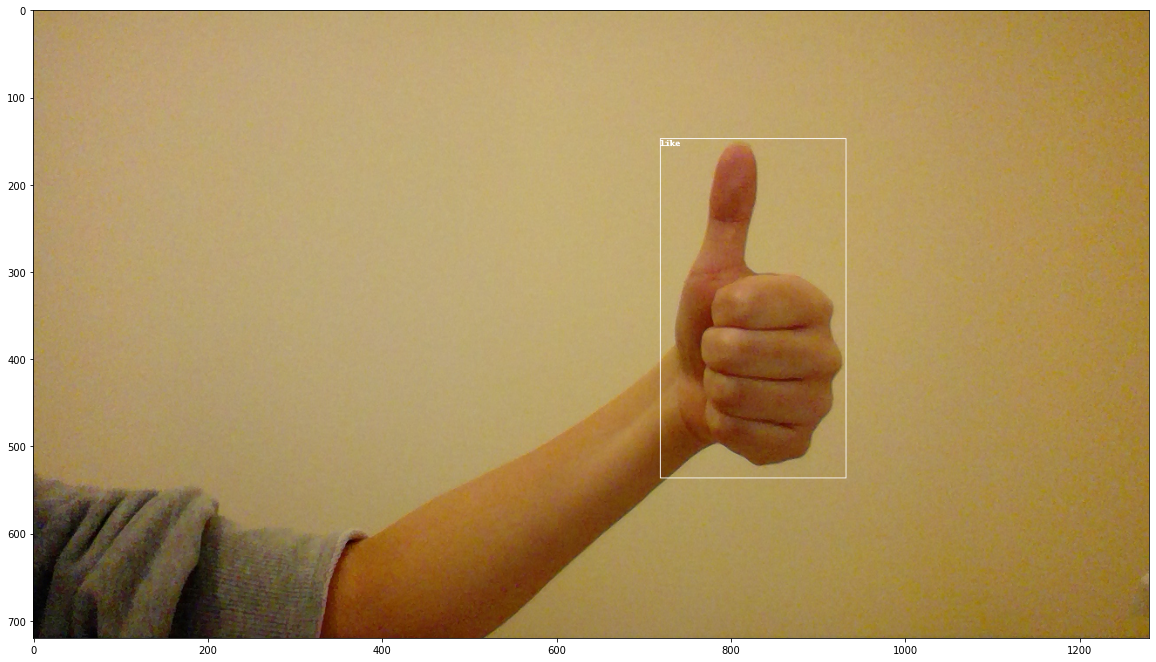

In [19]:
# pick one image from the test set
img, targets = test_dataset[40]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
    # BBox IoU
    ious = torchvision.ops.box_iou(prediction[0]['boxes'], target['boxes'].to(device)).squeeze()
    boxes = prediction[0]['boxes']
    # bbox_indices = torchvision.ops.nms(boxes, ious, iou_thresh)
    # boxes = boxes[bbox_indices]
    labels = [classes[l] for l in prediction[0]['labels']] #[bbox_indices]]
    if (len(boxes) > 0):
        # Draw the bounding boxes on our image
        img = draw_bounding_boxes((img * 255).to(torch.uint8), boxes, labels)
        plt.figure(figsize=(20,20))
        plt.imshow(img.permute(1,2,0))
    else:
        print('No predictions for image!')
        plt.figure(figsize=(20,20))
        plt.imshow(img.permute(1,2,0))